In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torch import optim
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pathlib import Path


In [2]:
file ='AI_Powered_Eduction_system'
def root(root_name:str=file):
    for parent in Path().resolve().parents:
        if parent.name == root_name:
            return(parent) 
ROOT = root()

In [3]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Udith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Udith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
stop_words = stopwords.words('english')
punctuations = string.punctuation
lemmatizer = WordNetLemmatizer()

In [5]:
def preprocess(txt):
    txt=txt.lower()
    txt = re.sub(r'[^A-Za-z0-9\s]','',txt)
    clean_text = nltk.word_tokenize(txt)
    clean_text = [word for word in clean_text if word not in stop_words and word not in punctuations]
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
    return ' '.join(clean_text)


In [6]:
essay_df = pd.read_csv(ROOT/r'data\Train_datasets\Topic_Detector\essays_data.csv',encoding='latin-1')
essay_df.head()

,title,description,essay,authors,source_url,thumbnail_url
0,Space exploration,When self-replicating craft bring life to the ...,"Some time late this century, someone will push...",Jay Olson,https://aeon.co//essays/cosmic-expansion-is-a-...,https://images.aeonmedia.co/images/9239658f-b9...
1,History of science,"To the detriment of the public, scientists and...",Would boycotting Russian scientists be an effe...,Lorraine Daston & Peter Harrison,https://aeon.co//essays/science-and-history-ca...,https://images.aeonmedia.co/images/7e9ea9e3-03...
2,Religion,"Once a centre of Afghan culture, Sufism seems ...",My introduction into the world of Afghanistanâ...,Annika Schmeding,https://aeon.co//essays/sufi-transitions-betwe...,https://images.aeonmedia.co/images/957fb6c9-40...
3,Thinkers and theories,The intrepid logician Kurt GÃ¶del believed in ...,"As the foremost logician of the 20th century, ...",Alexander T Englert,https://aeon.co//essays/kurt-godel-his-mother-...,https://images.aeonmedia.co/images/cbe24f46-98...
4,Thinkers and theories,"For Rachel Bespaloff, philosophy was a sensual...",Shortly after Rachel Bespaloffâs suicide in ...,Isabel Jacobs,https://aeon.co//essays/for-rachel-bespaloff-p...,https://images.aeonmedia.co/images/536e31b1-dc...


In [7]:
essay_df=essay_df.iloc[:,:2]
essay_df.head()

,title,description
0,Space exploration,When self-replicating craft bring life to the ...
1,History of science,"To the detriment of the public, scientists and..."
2,Religion,"Once a centre of Afghan culture, Sufism seems ..."
3,Thinkers and theories,The intrepid logician Kurt GÃ¶del believed in ...
4,Thinkers and theories,"For Rachel Bespaloff, philosophy was a sensual..."


In [8]:
len(essay_df['title'].unique())

114

In [9]:
len(essay_df)

2235

In [10]:
counts = essay_df['title'].value_counts()
rare_titles = counts[counts<=10].index
essay_df['title'] = essay_df['title'].apply(lambda x:'Other' if x in rare_titles else x)

In [11]:
essay_df['clean_text']=essay_df['description'].apply(preprocess)

<Axes: xlabel='length'>

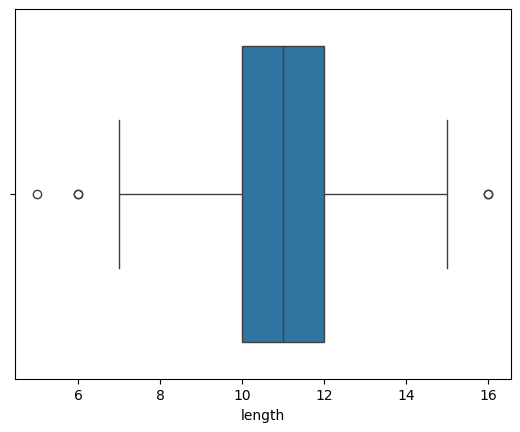

In [12]:
essay_df['length'] = essay_df['clean_text'].apply(lambda x:len(x.split()))
sns.boxplot(essay_df,x='length')

In [13]:
X = essay_df['clean_text']
y = essay_df['title']

In [14]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [15]:
class_weights = compute_class_weight('balanced',classes=y_train.unique(),y=y_train)
weight_tensor = torch.tensor(class_weights,dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)
num_classes = len(y.unique())

In [16]:
num_classes

76

In [17]:
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(x_train)
x_train=tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train,maxlen=50)
x_test = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test,maxlen=50)

In [18]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [19]:
class text_dataset(Dataset):
    def __init__(self,x,y):
        self.text = x
        self.title = y.astype(np.int64)
    def __len__(self):
        return len(self.title)
    def __getitem__(self, idx):
        text = torch.tensor(self.text[idx])
        title = torch.tensor(self.title[idx],dtype=torch.long)
        return text,title

In [20]:
train_data = text_dataset(x_train_pad,y_train)
train_loader = DataLoader(train_data,batch_size=4,shuffle=True)
val_data = text_dataset(x_test,y_test)
val_loader = DataLoader(train_data,batch_size=2,shuffle=True)

In [21]:
print(len(tokenizer.word_index)+1)

6997


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
text,title = next(iter(train_loader))
print(text.shape)

torch.Size([4, 50])


In [24]:
class Net(nn.Module):
    def __init__(self,num_classes,input_size=1):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=10000,embedding_dim=50)
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=32,num_layers=2,batch_first=True)
        self.lin = nn.Linear(32,num_classes)
    def forward(self,x):
        x = self.embedding(x)
        h0 = torch.zeros(2,x.size(0),32)
        c0 = torch.zeros(2,x.size(0),32)
        out,_ = self.lstm(x,(h0,c0))
        out = self.lin(out[:,-1,:])
        return out


In [25]:
classifier = Net(num_classes=num_classes,input_size=50)
optimizer = optim.Adam(classifier.parameters(),lr=0.001)

In [26]:
from torchmetrics import Precision,Recall
met_prec = Precision(task='multiclass',num_classes=num_classes,average='macro')
met_rec = Recall(task='multiclass',num_classes=num_classes,average='macro')

In [27]:
classifier.train(True)
for epoch in range(20):
    for text,title in train_loader:
        optimizer.zero_grad()
        output = classifier(text)
        loss = criterion(output,title)
        loss.backward()
        optimizer.step()
    print(f'epoch:{epoch}')

epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
epoch:10
epoch:11
epoch:12
epoch:13
epoch:14
epoch:15
epoch:16
epoch:17
epoch:18
epoch:19


In [28]:
classifier.eval()
with torch.no_grad():
    for text,title in val_loader:
        output = classifier(text)
        _,preds =torch.max(output,1)
        met_prec(preds,title)
        met_rec(preds,title)
precision = met_prec.compute()
recall = met_rec.compute()
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.9603174924850464
Recall: 0.9612119197845459


In [29]:
import pickle as pkl

In [34]:
filename = ROOT/r'Models\Topic_Detector\encoder.sav'
pkl.dump(encoder,open(filename,'wb'))
token_filename = ROOT/r'Models\Topic_Detector\tokenizer.sav'
pkl.dump(tokenizer,open(token_filename,'wb'))

In [35]:
torch.save(classifier.state_dict(),ROOT/r'Models\Topic_Detector\topic_model_weights.pth')